In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def read_csv(path):
    data = pd.read_csv(path)
    X = np.stack((np.array(data['x']), np.array(data['y'])), axis = 1)
    y = np.array(data['label'], dtype=np.uint8)
    return X, y

In [24]:
np.random.seed(42)

In [25]:
from src.classifier.MultivariateGaussianClassifier import GaussianNaiveBayesClassifier

In [26]:
from src.classifier.KNNClassifier import KNNClassifier

In [28]:
from src.metrics.accuracy import accuracy

In [29]:
def plot_classification_boundary(classifier, X_data, y_data, part):

    #creating grid points
    grid_axis_pts = 100

    x_min = np.min(X_data[:, 0])
    x_max = np.max(X_data[:, 0])
    x_range = x_max - x_min

    y_min = np.min(X_data[:, 1])
    y_max = np.max(X_data[:, 1])
    y_range = y_max - y_min

    x_axis = np.linspace(x_min - x_range * 0.25, x_max + x_range * 0.25, grid_axis_pts)
    y_axis = np.linspace(y_min - y_range * 0.25, y_max + y_range * 0.25, grid_axis_pts)

    x1, x2 = [], []
    for x1_ in x_axis:
        for x2_ in y_axis:
            x1.append(x1_)
            x2.append(x2_)
    x1 = np.array(x1)
    x2 = np.array(x2)
    X = np.stack([x1, x2], axis=1) # all points in grid
    
    # predicting dor grid points
    y_pred = classifier.predict(X)

    #colors and markers for plotting decision boundary and data points
    colors = ['g', 'r', 'b', 'm', 'y', 'k']
    markers = ['o', '^', 's', 'x']
    y_pred_colors = []
    y_data_colors = []
    for c in y_pred:
        y_pred_colors.append(colors[c])
    for c in y_data:
        y_data_colors.append(colors[-1 - c])
    
    #plot
    plt.figure(figsize=(4,4))
    
    #decision boundary
    plt.scatter(x1, x2, c=y_pred_colors, s=5)
    
    #test data
    labels = np.unique(y_data)
    y_min = np.min(y_data)
    labels -= y_min
    for class_code in labels:
        x = X_data[y_data == class_code]
        plt.scatter(x[:,0], x[:,1], label="Class - {}".format(class_code + y_min), marker=markers[class_code], c = colors[-1 - class_code])
        
    title_text = "Part_{}_Decision_Boundary".format(part)
    plt.title(title_text)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.legend()
    plt.savefig(title_text)
    plt.show()
    

In [30]:
from src.metrics.conf_matrix import confusion_matrix

In [31]:
train_path_2 = "./dataset/d2/train_39.csv"
X_train_2, y_train_2 = read_csv(train_path_2)
test_path_2 = "./dataset/d2/test_39.csv"
X_test_2, y_test_2 = read_csv(test_path_2)

In [32]:
train_path_3 = "./dataset/d3/train_39.csv"
X_train_3, y_train_3 = read_csv(train_path_3)
test_path_3 = "./dataset/d3/test_39.csv"
X_test_3, y_test_3 = read_csv(test_path_3)

In [33]:
def plot_part(classifier, X_train, y_train, X_test, y_test, cov_matrix, part):
    classifier.fit(X_train, y_train, cov_matrix)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    
    # Accuracy
    print("\nACCURACY\n")
    train_acc = accuracy(y_train_pred, y_train)
    test_acc = accuracy(y_test_pred, y_test)
    print("train:\t", train_acc)
    print("test:\t", test_acc)

    # classification boundary
    print("\nCLASSIFICATION BOUNDARY\n")
    plot_classification_boundary(classifier, X_test, y_test, part)
    
    # confusion matrix
    print("\nCONFUSION MATRIX\n")
    print("\nTRAINING CONFUSION MATRIX")
    confusion_matrix(y_train_pred, y_train, "Part_{}_Train_Data".format(part))
    print("\nTESTING CONFUSION MATRIX")
    confusion_matrix(y_test_pred, y_test, "Part_{}_Test_Data".format(part))

In [34]:
def knn_analysis(X, y, X_test, y_test, k_min = 1, k_max = 20, val_split_ratio = 0.2, part = '3'):
    k_vals = np.arange(k_min, k_max, 1)
    train_acc = np.zeros(k_max - k_min)
    val_acc = np.zeros(k_max - k_min)
    data = np.c_[X, y]
    n_train_samples = int(X.shape[0]*(1-val_split_ratio))
    for k in range(k_min, k_max):
        np.random.shuffle(data)
        X_train, y_train = data[:n_train_samples, :-1], data[:n_train_samples, -1]
        X_val, y_val = data[n_train_samples:, :-1], data[n_train_samples:, -1]

        knn = KNNClassifier(k)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_val_pred = knn.predict(X_val)
        train_acc[k - k_min] = accuracy(y_train_pred, y_train)
        val_acc[k - k_min] = accuracy(y_val_pred, y_val)

    plt.plot(k_vals, train_acc, label='training accuracy')
    plt.plot(k_vals, val_acc, label='validation_accuracy')
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.legend()
    title_text = "Part_{}_Accuracy_vs_K".format(part)
    plt.title(title_text)
    plt.savefig(title_text)
    plt.show()

    k_best = int(np.argmax(val_acc) + k_min)
    
    print("According to the plot above, Best K : \t", k_best)


    knn = KNNClassifier(k_best)
    knn.fit(X, y)

    y_train_pred = knn.predict(X)
    y_test_pred = knn.predict(X_test)

    y_train_acc = accuracy(y_train_pred, y)
    y_test_acc = accuracy(y_test_pred, y_test)

    print("Training Accuracy:\t\t", y_train_acc)
    print("Testing Accuracy:\t\t", y_test_acc)

    print("\nCLASSIFICATION BOUNDARY\n")
    plot_classification_boundary(knn, X_test, y_test, part)

    print("\nCONFUSION MATRIX\n")
    print("\nTRAINING CONFUSION MATRIX")
    print(confusion_matrix(y_train_pred, y, "Part_{}_Train_Data".format(part)))
    print("\nTESTING CONFUSION MATRIX")
    print(confusion_matrix(y_test_pred, y_test, "Part_{}_Test_Data".format(part)))

In [35]:
gnbc = GaussianNaiveBayesClassifier()

## Q2 - PART A


ACCURACY

train:	 0.996
test:	 1.0

CLASSIFICATION BOUNDARY



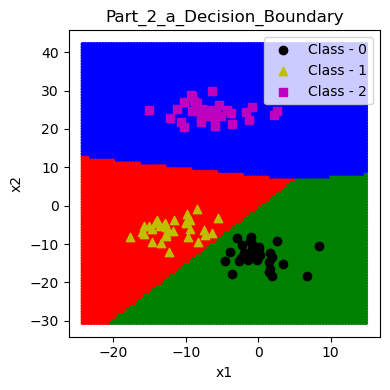


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


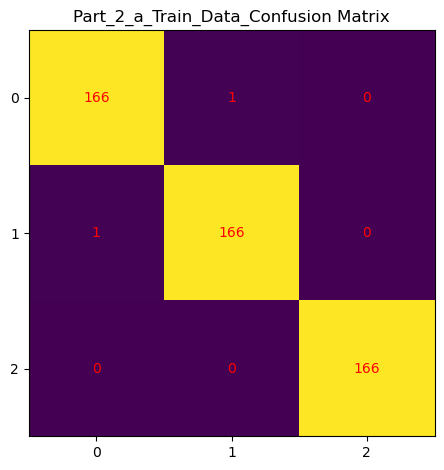


TESTING CONFUSION MATRIX


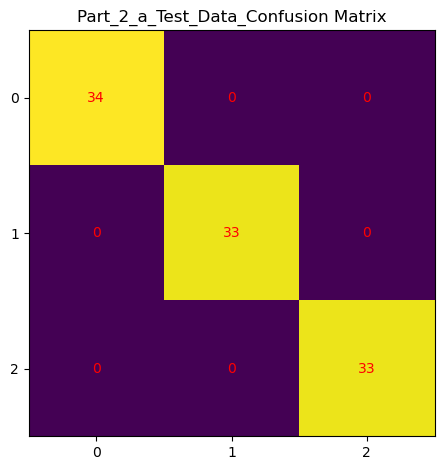

In [36]:
plot_part(gnbc, X_train_2, y_train_2, X_test_2, y_test_2, "identity", part='2_a')

## Q2 - PART B


ACCURACY

train:	 0.788
test:	 0.76

CLASSIFICATION BOUNDARY



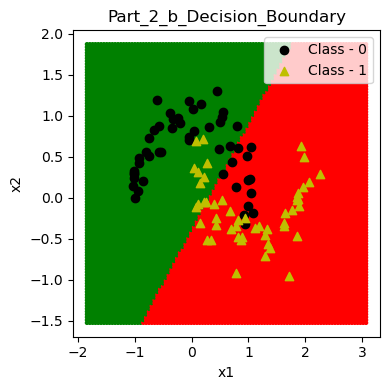


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


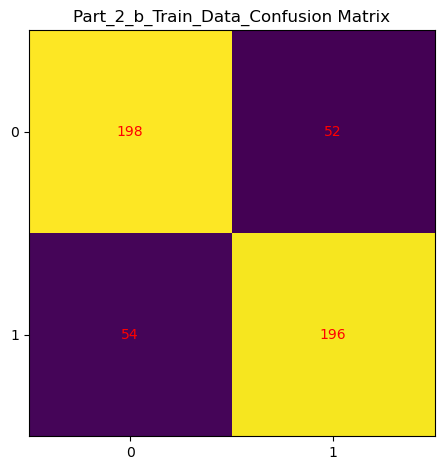


TESTING CONFUSION MATRIX


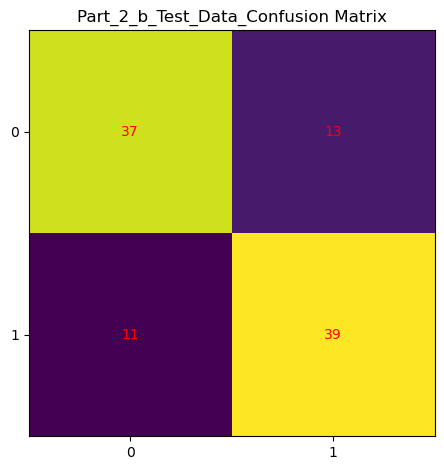

In [37]:
plot_part(gnbc, X_train_3, y_train_3, X_test_3, y_test_3, "identity", part='2_b')

## Q2 - PART C


ACCURACY

train:	 0.992
test:	 0.99

CLASSIFICATION BOUNDARY



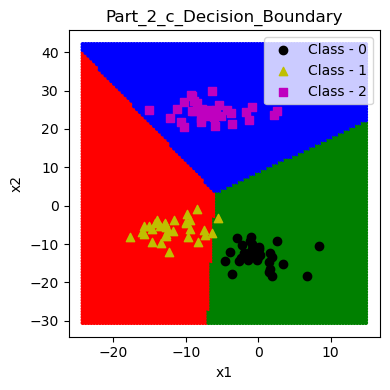


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


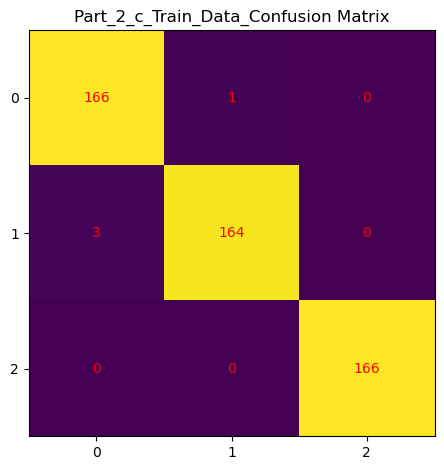


TESTING CONFUSION MATRIX


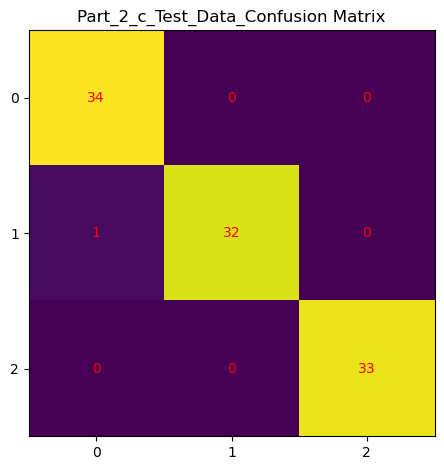

In [38]:
plot_part(gnbc, X_train_2, y_train_2, X_test_2, y_test_2, "same", part='2_c')

## Q2 - PART D


ACCURACY

train:	 0.868
test:	 0.85

CLASSIFICATION BOUNDARY



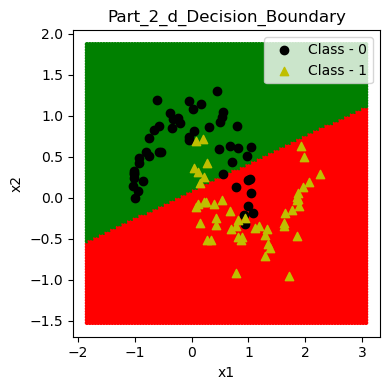


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


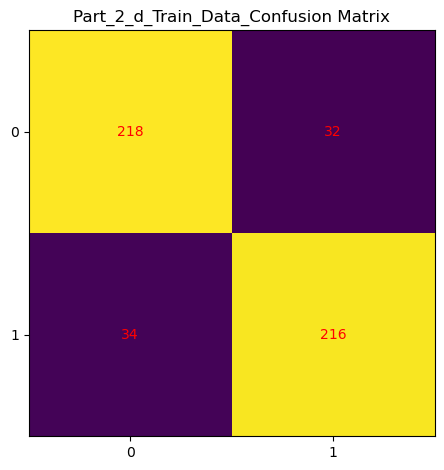


TESTING CONFUSION MATRIX


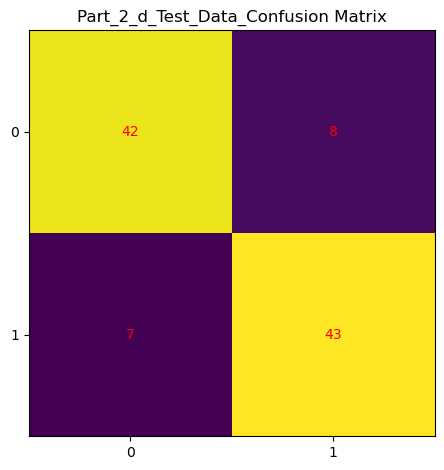

In [39]:
plot_part(gnbc, X_train_3, y_train_3, X_test_3, y_test_3, "same", part='2_d')

## Q2 - PART E


ACCURACY

train:	 0.996
test:	 1.0

CLASSIFICATION BOUNDARY



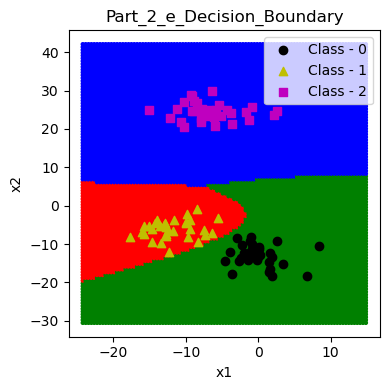


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


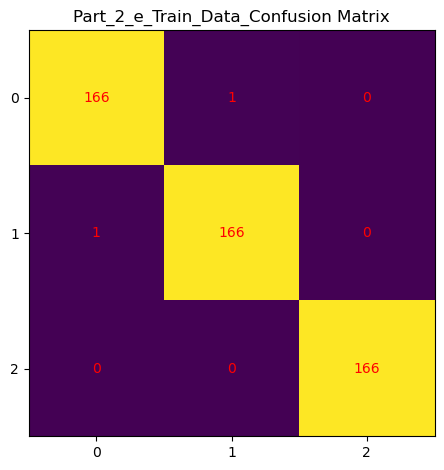


TESTING CONFUSION MATRIX


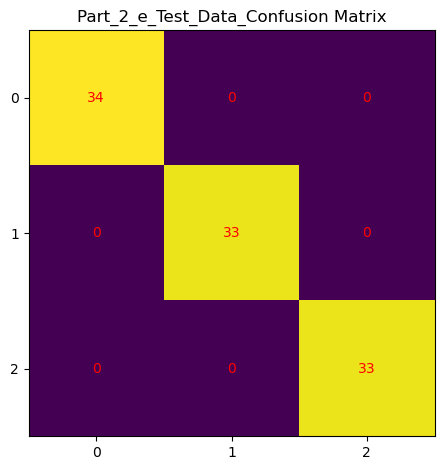

In [40]:
plot_part(gnbc, X_train_2, y_train_2, X_test_2, y_test_2, "different", part='2_e')

## Q2 - PART F


ACCURACY

train:	 0.866
test:	 0.85

CLASSIFICATION BOUNDARY



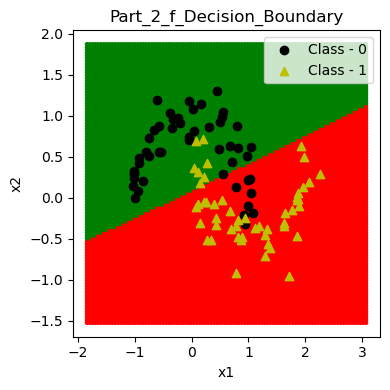


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


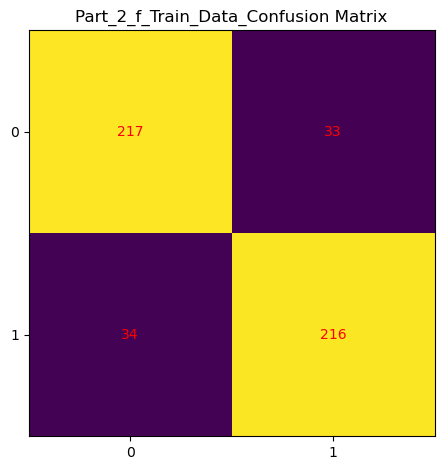


TESTING CONFUSION MATRIX


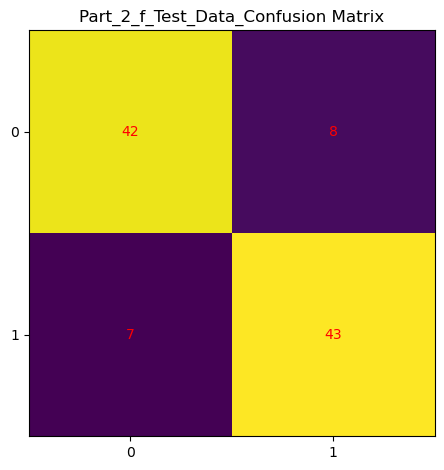

In [41]:
plot_part(gnbc, X_train_3, y_train_3, X_test_3, y_test_3, "different", part='2_f')

# Q3

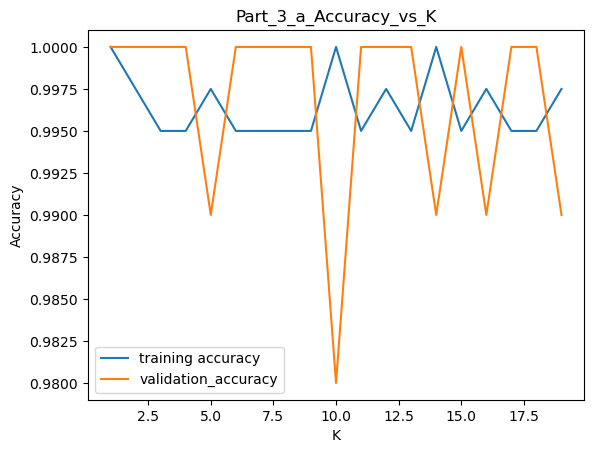

According to the plot above, Best K : 	 1
Training Accuracy:		 1.0
Testing Accuracy:		 1.0

CLASSIFICATION BOUNDARY



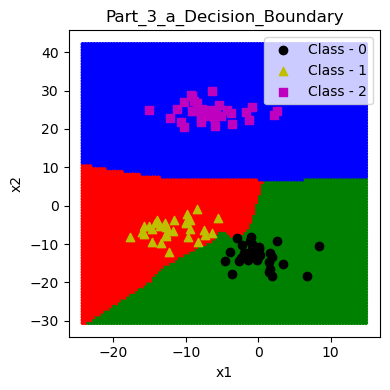


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


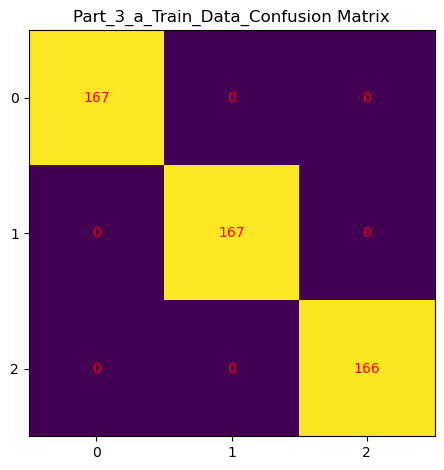

[[167   0   0]
 [  0 167   0]
 [  0   0 166]]

TESTING CONFUSION MATRIX


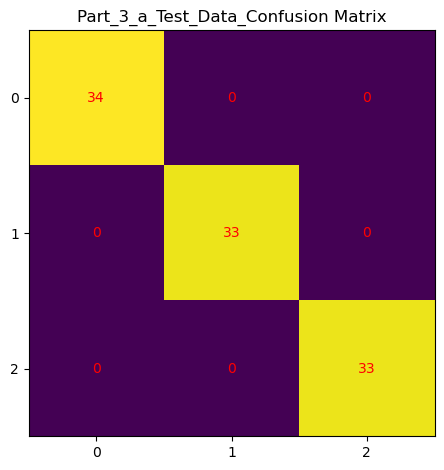

[[34  0  0]
 [ 0 33  0]
 [ 0  0 33]]


In [42]:
knn_analysis(X_train_2, y_train_2, X_test_2, y_test_2, 1,20, 0.2, '3_a')

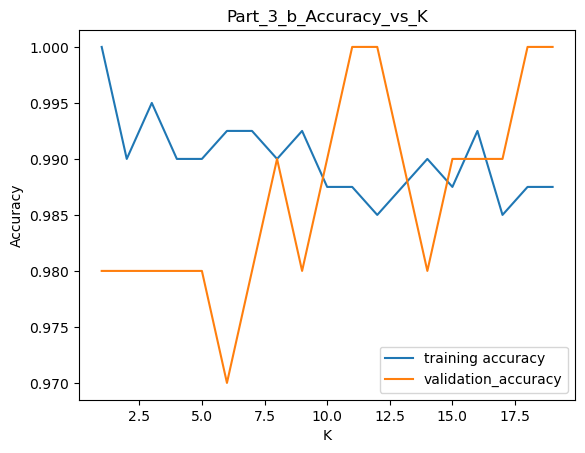

According to the plot above, Best K : 	 11
Training Accuracy:		 0.988
Testing Accuracy:		 0.95

CLASSIFICATION BOUNDARY



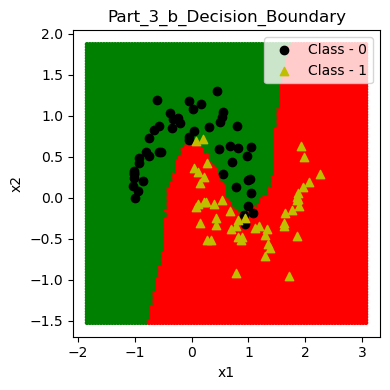


CONFUSION MATRIX


TRAINING CONFUSION MATRIX


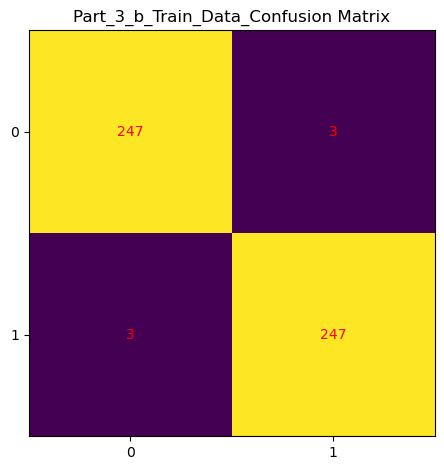

[[247   3]
 [  3 247]]

TESTING CONFUSION MATRIX


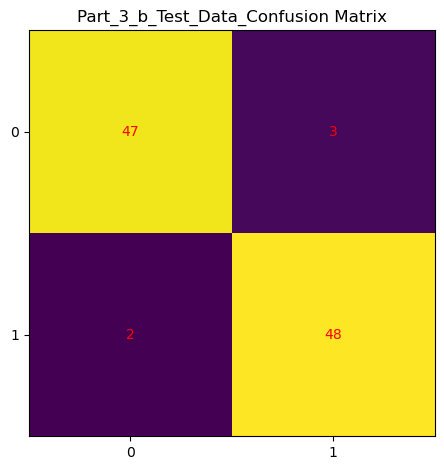

[[47  3]
 [ 2 48]]


In [43]:
knn_analysis(X_train_3, y_train_3, X_test_3, y_test_3, 1,20, 0.2, '3_b')